# Latent Representation

based on the paper "Hard to beat baseline"

In [82]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import manifold,neighbors
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree, fcluster,distance  
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo
from tqdm import tqdm

In [2]:
word_vectors = Word2Vec.load_word2vec_format('/data/genomes/embeddings/dna2vec-20190612-1611-k10to10-100d-10c-4870Mbp-sliding-kPR.w2v')

In [3]:
FASTA="/data/genomes/dna2vec_train/"
ff = glob.glob(f"{FASTA}*.fasta")
X = {}
for file in tqdm(ff):
    for record in SeqIO.parse(file, "fasta"):
        seq=str(record.seq)
        t = ["".join(seq[i:i+10]) for i in range(len(seq)-10)]
        tokens = list(filter(lambda x: set(x) == {'A', 'C', 'G', 'T'}, t))
        vectors = word_vectors[tokens]
        X[record.id]=np.mean(vectors, axis=0)

100%|██████████| 4715/4715 [19:38<00:00,  4.00it/s]  


In [4]:
len(X)

4715

In [ ]:
df = pd.DataFrame().from_dict(X,orient="index")

In [220]:
df.to_pickle("../data/kls.pkl")

In [71]:
pca          = pd.DataFrame(data=PCA(n_components=3).fit_transform(df.values),
                             columns=["pc1",'pc2',"pc3"])

In [1]:
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111,projection="3d")
ax.scatter(pca.loc[:,"pc1"],pca.loc[:,"pc2"],pca.loc[:,"pc3"], marker="o",s=1,color='r', label = "no denoize")
ax.scatter(0.,0.,0.,marker="X",color="k", label="center of space")
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
ax.set_title("latent space")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

### Denoising

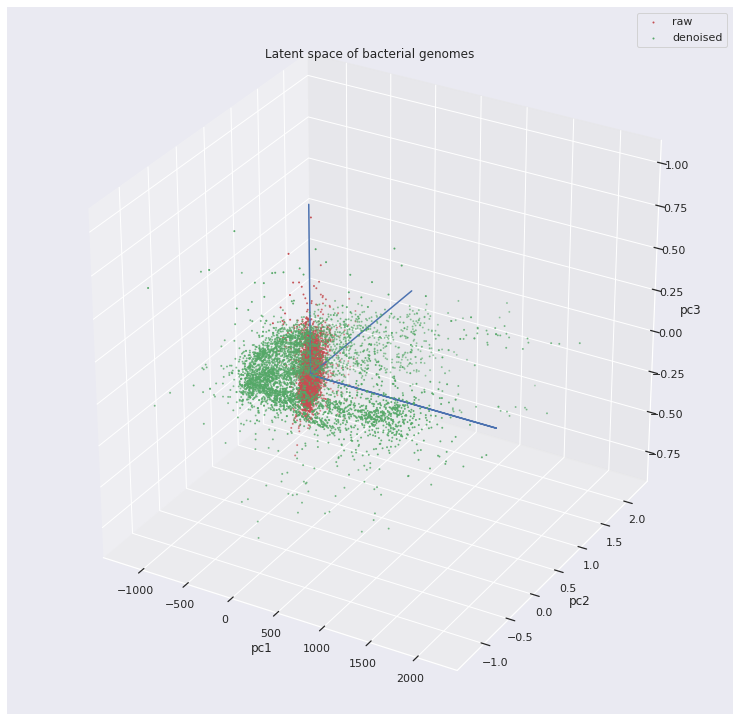

In [104]:
fc = PCA(n_components=1).fit_transform(df.values.T)
denoiser = np.dot(fc,fc.T)
X_dn = [x - np.dot(denoiser,x) for x in df.values]

pca_dn = pd.DataFrame(data=PCA(n_components=3).fit_transform(X_dn),
                             columns=["pc1",'pc2',"pc3"])

fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111,projection="3d")
ax.scatter(pca.loc[:,"pc1"],pca.loc[:,"pc2"],pca.loc[:,"pc3"], marker="o",s=1,color='r', label = "raw")
ax.scatter(pca_dn.loc[:,"pc1"],pca_dn.loc[:,"pc2"],pca_dn.loc[:,"pc3"], marker="o",s=1,color='g', label = "denoised")
ax.plot((0.,0.,0.),(2.,0.,0.),(0.,0.,0.), color = "b")
ax.plot((0.,2000.,0.),(0.,0.,0.),(0.,0.,0.), color = "b")
ax.plot((0.,0.,0.),(0.,0.,0.), (0.,0.,1.), color = "b")
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
ax.set_title("Latent space of bacterial genomes")
plt.legend()
plt.show()

In [221]:
pd.DataFrame(X_dn).to_pickle("../data/kls_denoised.pkl")